# JData

In [1]:
import pdb
import random
from collections import OrderedDict
from imp import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import SVG, display

from jdata import JData
from jdata_counties import JDataCounties
from map_maker import draw_county_data_svg
from probplots import plot_dists_pps
from utilities import (display_cb, is_outlier_instance, is_outlier_val,
                       read_fips_codes)

%matplotlib inline

SEED = 42
random.seed(SEED)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

DATA_DIR    = '../Data/'
IMG_DIR     = '../Images/'
DEM_DIR     = ''.join([DATA_DIR, 'Demography/'])
SCL_DIR     = ''.join([DATA_DIR, 'Schools/'])

ZIPS_TO_FIPS_FP = ''.join([DATA_DIR, 'ZIP_COUNTY_122016.xlsx'])

SVG_FP = ''.join([IMG_DIR, 'temp.svg'])  # for exploring

JDATA_FP = ''.join([SCL_DIR, 'jdata_directory.json'])


In [2]:
jdata = JData()
jd_df = jdata.read_orgs(JDATA_FP)

## Clean Dupes

In [3]:
jd_df = jd_df[
    ~jd_df.duplicated(['Addr', 'Zip', 'Type', 'Denom'], keep='first')]

- 40 out of 3861 records have same Addr, Zip, and Type.
- No further deduping necessary

In [4]:
jd_df[jd_df.duplicated(['URL'], keep=False)].shape

(1747, 10)

In [5]:
jd_df[jd_df.duplicated(['Name', 'Zip'], keep=False)]

,Name,Addr,City,State,Zip,Country,Phone,URL,Type,Denom
2104,The Religious School at Temple Israel and Agud...,5419 East Broad Street,Columbus,OH,43213,US,614-866-0010,http://www.templeisrael.org,PTSch,Ref
3388,The Religious School at Temple Israel and Agud...,5419 East Broad Street; Temple Israel,Columbus,OH,43213,US,614-866-0010,http://www.templeisrael.org,PTSch,Oth


In [6]:
dupe_addr = jd_df[jd_df.duplicated(['Addr', 'Zip'], keep=False)].sort_values(['Addr', 'Zip'])
dupe_addr.T

,860,2084,2503,570,1581,619,2052,159,1403,532,...,186,679,1313,3047,961,2276,632,1897,845,2220
Name,The Maui Hebrew Academy,Temple Tifereth Israel Religious School,JRCC Hebrew School,Temple Emanu-El Nursery School,Congregation Emanu-El of the City of New York ...,Temple Sinai of Bergen County Early Childhood ...,Temple Sinai of Bergen County Religious School,JCamps,Merage JCC of Orange County Preschool,Temple Am Echad Early Childhood Center,...,Marleen Forkas Camps,Betty and Marvin Zale Early Childhood Learning...,Kehilat Shalom Early Childhood Center,Kehilat Shalom Religious School,Garden Preschool,Chabad Hebrew School of South Metro Denver,The Early Childhood Education Center at Temple...,Temple Beth Tikvah Religious School of Roswell,Temple Samu-El Or Olom Early Childhood Center,Temple Samu-El Or Olom Religious School
Addr,,,,1 East 65th Street,1 East 65th Street,1 Engle Street,1 Engle Street,1 Federation Way; Suite 200,1 Federation Way; Suite 200,1 Saperstein Plaza,...,9801 Donna Klein Boulevard,9801 Donna Klein Boulevard,9915 Apple Ridge Road,9915 Apple Ridge Road,9950 Lone Tree Parkway,9950 Lone Tree Parkway,9955 Coleman Road,9955 Coleman Road,Temple Samu-El Or Olom; 10680 SW 113 Place,Temple Samu-El Or Olom; 10680 SW 113 Place
City,Maui,,Thornhill,New York,New York,Tenafly,Tenafly,Irvine,Irvine,Lynbrook,...,Boca Raton,Boca Raton,Gaithersburg,Gaithersburg,Lone Tree,Lone Tree,Roswell,Roswell,Miami,Miami
State,HI,MA,ON,NY,NY,NJ,NJ,CA,CA,NY,...,FL,FL,MD,MD,CO,CO,GA,GA,FL,FL
Zip,None,None,None,10065,10065,07670,07670,92603,92603,11563,...,33428,33428,20886,20886,80124,80124,30075,30075,33176,33176
Country,None,None,None,US,US,US,US,US,US,US,...,US,US,US,US,US,US,US,US,US,US
Phone,None,None,647-284-6554,212-744-1400,212-744-1400,201-568-3035,201-568-3075,949-435-3400,949-435-3400,516-599-7950,...,561-852-5090,561-852-3286,301-869-1929,301-869-7699,303-694-9119,303-792-7222,678-350-0076,770-642-4168,271-5756,271-5756
URL,http://mauiha.blogspot.com,None,http://www.jrcc.org,http://www.emanuelnyc.org,http://www.emanuelnyc.org,http://www.templesinaibc.org,http://www.templesinaibc.org,http://www.jccoc.org/main/jcamps,http://www.jccoc.org,http://www.am-echad.org,...,http://www.levisjcc.org,http://www.levisjcc.org,None,http://www.kehilatshalom.org,http://www.GardenPreschool.com,http://www.denverjewishcenter.com,http://www.bethtikvah.com,http://www.bethtikvah.com,http://www.tsoomiami.org,http://www.tsoomiami.org
Type,EarlyChild,PTSch,PTSch,EarlyChild,PTSch,EarlyChild,PTSch,DayCamp,EarlyChild,EarlyChild,...,DayCamp,EarlyChild,EarlyChild,PTSch,EarlyChild,PTSch,EarlyChild,PTSch,EarlyChild,PTSch
Denom,None,Ref,Orth,Ref,Ref,Ref,Ref,None,Oth,Ref,...,None,None,Consv,Consv,Orth,Orth,Ref,Ref,None,None


In [7]:
dupe_addr.Type.value_counts()

EarlyChild    645
PTSch         590
DaySch        186
DayCamp        79
OverCamp       10
Name: Type, dtype: int64

## Clean Denoms

In [9]:
miscats_dict = jdata.get_miscats(jd_df, 'Denom', pretty_print=False)

# don't classfiy as a miscategorized Community when term appears in Addr field
miscats_dict['Comm'] = (miscats_dict['Comm']
                        .loc[~miscats_dict['Comm']
                        .Addr.str.contains('Comm',
                            case=False)])

# impute missing Denom vals
for type_, df in miscats_dict.items():
    missing = df[df.Denom=='None'].index
    jd_df.loc[missing, 'Denom'] = type_

In [10]:
jd_df.Denom.value_counts(normalize=True)*100

Orth        32.747
Ref         26.752
Consv       19.904
Comm         6.848
PlurTrans    5.356
Oth          4.050
Recon        2.212
Trad         0.773
Hum          0.453
Zionist      0.373
Sec          0.320
Seph         0.213
Name: Denom, dtype: float64

## Missing Denoms

__NOTE:__ The rest of imputations are done at the county count level by distributing number of missing denoms proportionally across their respective counties.

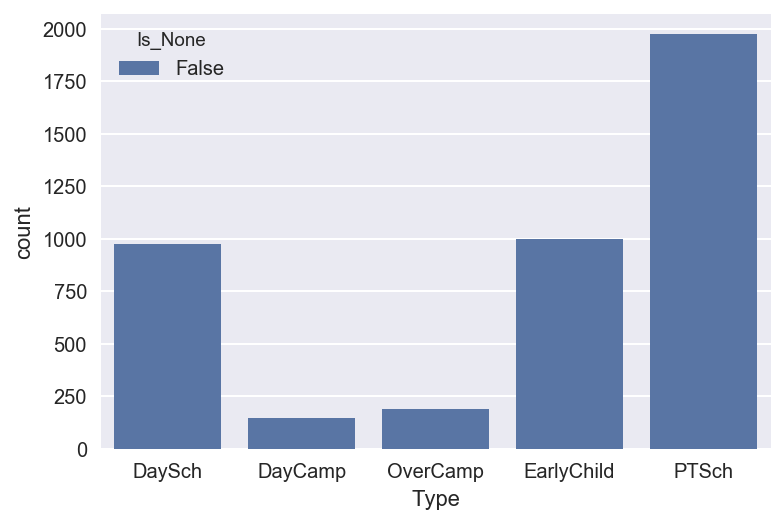

In [11]:
data = jd_df.assign(Is_None=jd_df.Denom=='None')
sns.countplot(x='Type', hue='Is_None', data=data)

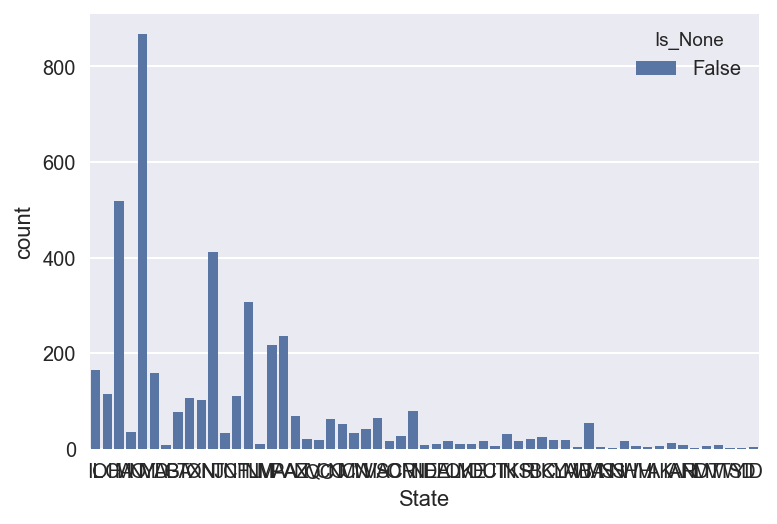

In [12]:
data = jd_df.assign(Is_None=jd_df.Denom=='None')
sns.countplot(x='State', hue='Is_None', data=data)

## Clean Types

Not necessary

In [14]:
jdata.get_miscats(jd_df, 'Type')['DaySch'].T

FOUND ELSEWHERE        ACTUAL CATEGORY        

 13 DaySch                 
                        10 EarlyChild
                         3 PTSch
  0 DayCamp                
  0 OverCamp               
  0 EarlyChild             
  0 PTSch                  


,536,744,760,771,789,794,814,1095,1187,1309,2560,2669,3364
Name,Temple Beth Am Day School Early Childhood Center,Hillel Day School of Boca Raton Early Childhoo...,Kadima Community Day School,Kindertots Preschool,Mazel Day School F.R.E.E. Preschool,MMSC Early Childhood Center,Sefi Day School Gan Osher,Ilan Ramon Day School - ECE,Junior Kindergarten at Chicago Jewish Day School,Kadima Hebrew Academy Early Childhood Center,Jewish Parents Institute Sunday School,The Friday School,Sunday School for Jewish Studies
Addr,5950 North Kendall Drive,21011 95th Avenue South,41 Central Street,1118 West Glendale Avenue,2901 Brighton 6th Street,8511 15th Avenue NE,380 Telegraph Canyon Road,27400 Canwood Street,5959 North Sheridan Road,7011 Shoup Avenue,6600 West Maple Road,401 Elmgrove Avenue,Oak Hill Middle School; 130 Wheeler Road
City,Pinecrest,Boca Raton,Andover,Phoenix,Brooklyn,Seattle,Chula Vista,Agoura Hills,Chicago,West Hills,West Bloomfield,Providence,Newton
State,FL,FL,MA,AZ,NY,WA,CA,CA,IL,CA,MI,RI,MA
Zip,33156,33428,01810,85021,11235,98115,91910,91301,60660,91307,48322,02906,02459
Country,US,US,US,US,US,US,US,US,US,US,US,US,US
Phone,305-665-6228,561-470-5000,978-475-5510,602-374-3062,718-368-4490,206-523-9766,619-422-7115,818-707-2365,773-271-2700,818-346-0849,248-432-5471,401-400-0755,617-264-8855
URL,http://www.tbam.org/dayschool,http://www.hilleldayschool.org,http://www.kadimadayschool.com/default.asp,http://www.torahdayschoolofphoenix.org,http://www.mazeldayschool.com,http://www.mmscdayschool.org,http://www.sefidayschool.com/#!meetourteachers...,http://www.ilanramondayschool.com,http://www.chicagojewishdayschool.org,http://www.kadimadayschool.org,http://www.jpisundayschool.org,http://www.thefridayschool.org,http://www.sundayschoolforjewishstudies.org
Type,EarlyChild,EarlyChild,EarlyChild,EarlyChild,EarlyChild,EarlyChild,EarlyChild,EarlyChild,EarlyChild,EarlyChild,PTSch,PTSch,PTSch
Denom,Ref,None,None,None,None,None,None,Comm,PlurTrans,Consv,Sec,PlurTrans,Oth


## Eliminate irrelevant schools

Ultra-Orthodox communities not on social media:
- Haredi and Hasidic yeshivas are only for boys, whereas girl attend Bais Yaakov schools (source: [Wiki][wiki]), [yeshivas wiki][yesh]
    - Keywords in org names: Bais/Beis Yaakov, Beis (3 schools)
    - ~~Haredi, Hasidic~~, ~~Yeshive, Bais~~ (too broad)
- CONCL: Not enough ultra-orthodox schools in database, not distinguishable from modern orthodox

[wiki]:https://en.wikipedia.org/wiki/Jewish_day_school
[yesh]:https://en.wikipedia.org/wiki/Yeshiva#Contemporary_Orthodox_yeshivas

__Is existence of URL important to determining ultraorthodox?__
- Nope, not good enough pattern below

In [15]:
for denom in jd_df.Denom.unique():
    n_nulls = (jd_df.loc[jd_df.URL.isnull()]
               .loc[jd_df.Denom==denom]
               .URL.isnull()
               .sum())
    print('{}: {}'.format(denom, n_nulls))

PlurTrans: 8
Trad: 1
Consv: 6
Oth: 5
None: 0
Ref: 11
Orth: 386
Sec: 0
Zionist: 0
Comm: 2
Recon: 0
Seph: 0
Hum: 0


In [16]:
jd_df[jd_df.Name.str.contains('Yeshiva', case=False)].Denom.value_counts()

jd_df[(jd_df.Name.str.contains('Yeshiva', case=False))
      & (jd_df.Denom!='Orth')].head()

,Name,Addr,City,State,Zip,Country,Phone,URL,Type,Denom
73,Yeshivat Ohr Chanoch,8906 West Pico Boulevard,Los Angeles,CA,90035,US,310-274-9800,http://www.ohrchanoch.org,DaySch,Oth
776,Lamplighters Yeshivah,823 Eastern Parkway,Brooklyn,NY,11213,US,718-355-9138,http://www.lamplightersyeshivah.com,EarlyChild,None
810,Rosenbaum Yeshiva of North Jersey Preschool,666 Kinderkamack Road,River Edge,NJ,07661,US,201-986-0078,http://www.ynj.org,EarlyChild,None
879,Yeshiva Elementary School Early Childhood Center,Yeshiva Elementary School; 7902 Carlyle Avenue,Miami Beach,FL,33141,US,305-867-3322,http://www.yeshivaelementaryschool.com,EarlyChild,None
880,Yeshiva Ohel Simcha ECC,14141 72nd Avenue,Flushing,NY,11367,US,718-261-0101,None,EarlyChild,None


## Visualizations

In [20]:
jd_df = JData().read_orgs(JDATA_FP, clean=True, combine_denoms=False)

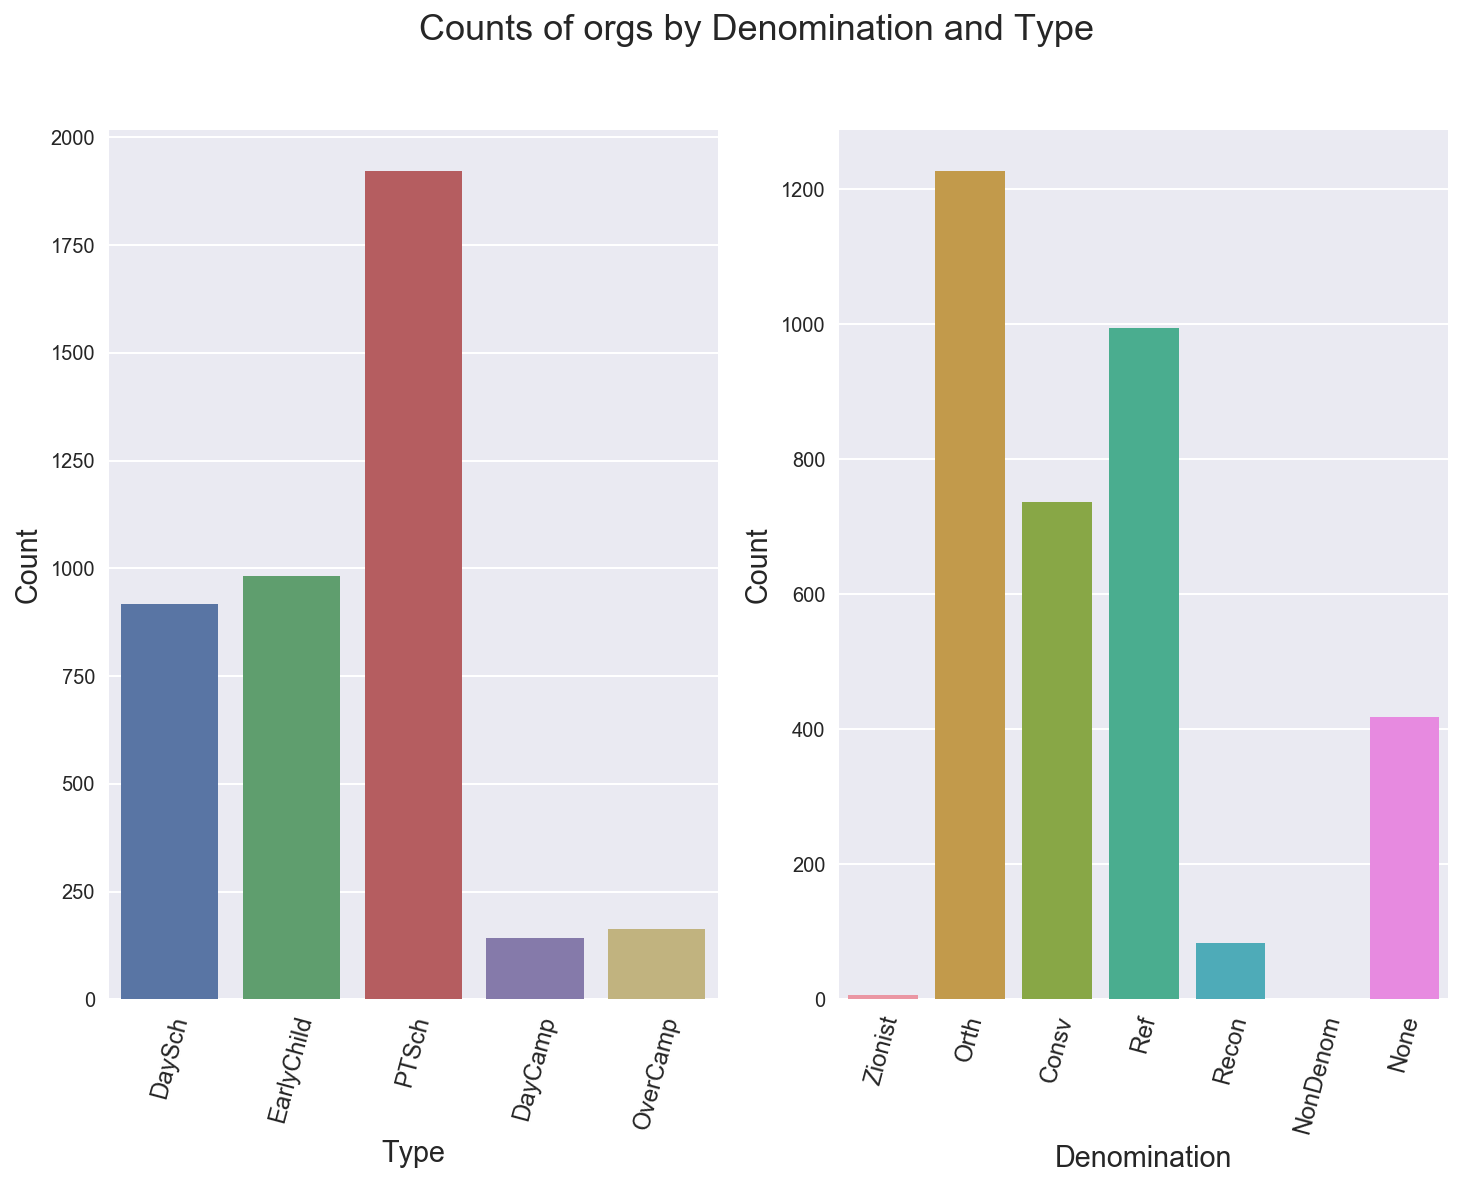

In [21]:
denom_order = ['Zionist', 'Orth', 'Consv', 'Ref', 'Recon', 'NonDenom', 'None']
type_order =  ['DaySch', 'EarlyChild', 'PTSch', 'DayCamp', 'OverCamp']
data = jd_df.fillna('None')

fig, (type_ax, denom_ax) = plt.subplots(ncols=2, figsize=(12, 8))


sns.countplot(x='Type', data=data, ax=type_ax, order=type_order)
sns.countplot(x='Denom', data=data, ax=denom_ax, order=denom_order)

lbl_size = 'x-large'
xticks_size = 'large'

type_ax.set_ylabel('Count', size=lbl_size)
type_ax.set_xlabel('Type', size=lbl_size)
type_ax.set_xticklabels(type_order, size=xticks_size, rotation=75)

denom_ax.set_ylabel('Count', size=lbl_size)
denom_ax.set_xlabel('Denomination', size=lbl_size)
denom_ax.set_xticklabels(denom_order, size=xticks_size, rotation=75)

plt.suptitle('Counts of orgs by Denomination and Type', size=18)

plt.show();

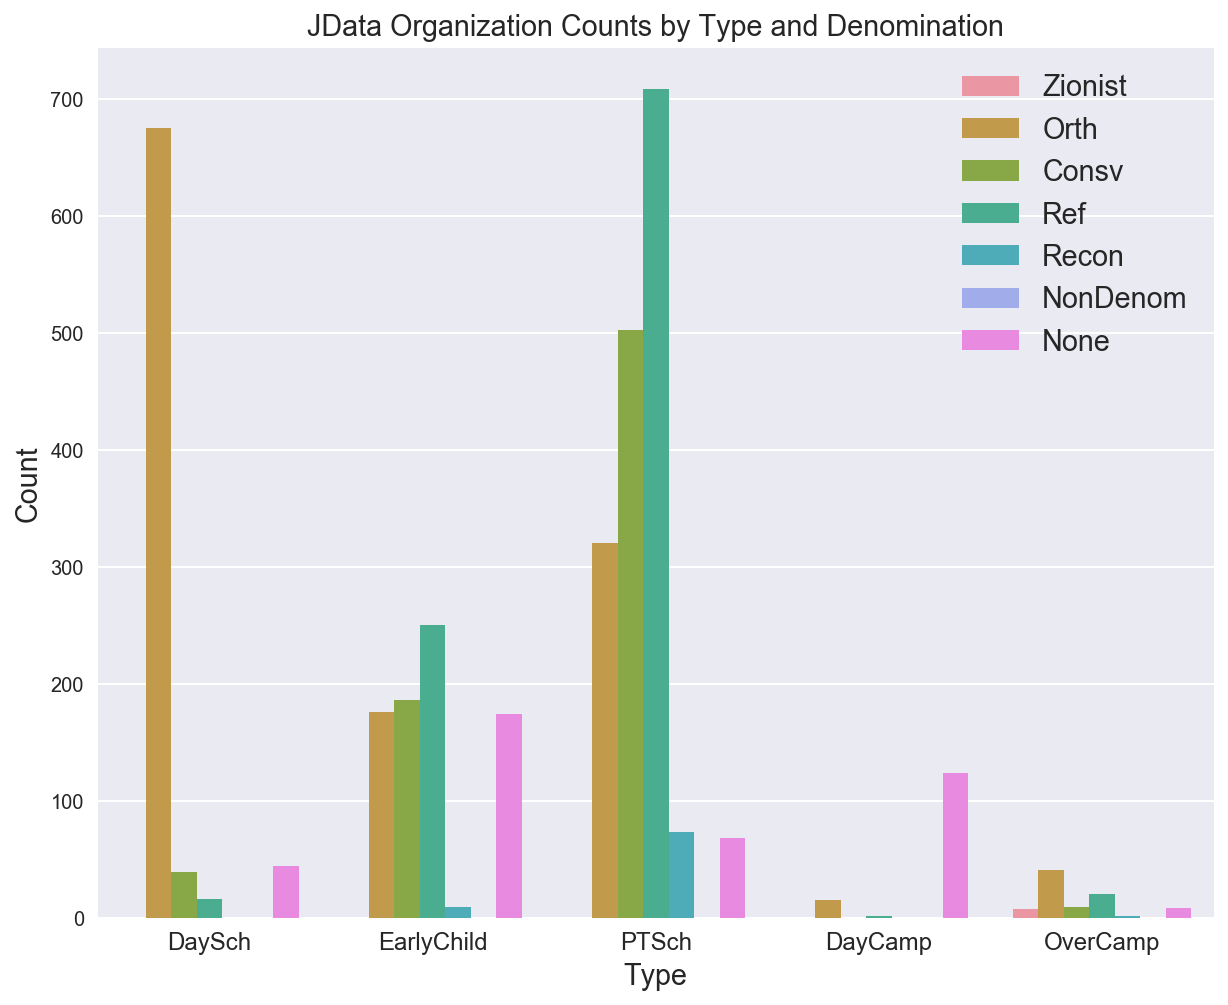

In [22]:
fig = plt.figure(figsize=(10, 8))
ax = sns.countplot(x='Type', hue='Denom', data=data,
                   order=type_order, hue_order=denom_order)


title_size = 'x-large'
lbl_size = 'x-large'
xticks_size = 'large'

ax.set_title('JData Organization Counts by Type and Denomination',
             fontsize=title_size)
ax.legend(fontsize=lbl_size, loc='best')

ax.set_ylabel('Count', fontsize=lbl_size)
ax.set_xlabel('Type', fontsize=lbl_size)
ax.set_xticklabels(type_order, fontsize=xticks_size)

plt.show();

Denominations:
- None
- Other
- Pluralist or Transdenominational
- Humanistic
- Community
- Secular
- Reconstructionist
- Reform
- Conservative
- Traditional
    - 21 orgs excl. 3 overnight camps
- Orthodox
- Zionist [drop]
    - 7 overnight camps
- Sephardic
    - Spain and Portuguese origins
    - 8 day/part-time schools in 7 counties

# JData County Counts

In [3]:
from imp import reload
import jdata_counties
import jdata
reload(jdata_counties)
reload(jdata)
from jdata_counties import JDataCounties
from jdata import JData

jdc = JDataCounties(JDATA_FP, ZIPS_TO_FIPS_FP)

In [4]:
cnty_df = jdc.get_county_cnts(exclude=['DayCamp', 'OverCamp'])

In [5]:
pd.DataFrame(cnty_df.iloc[:, 1:3]).equals(cnty_df.iloc[:, 1:3])

True

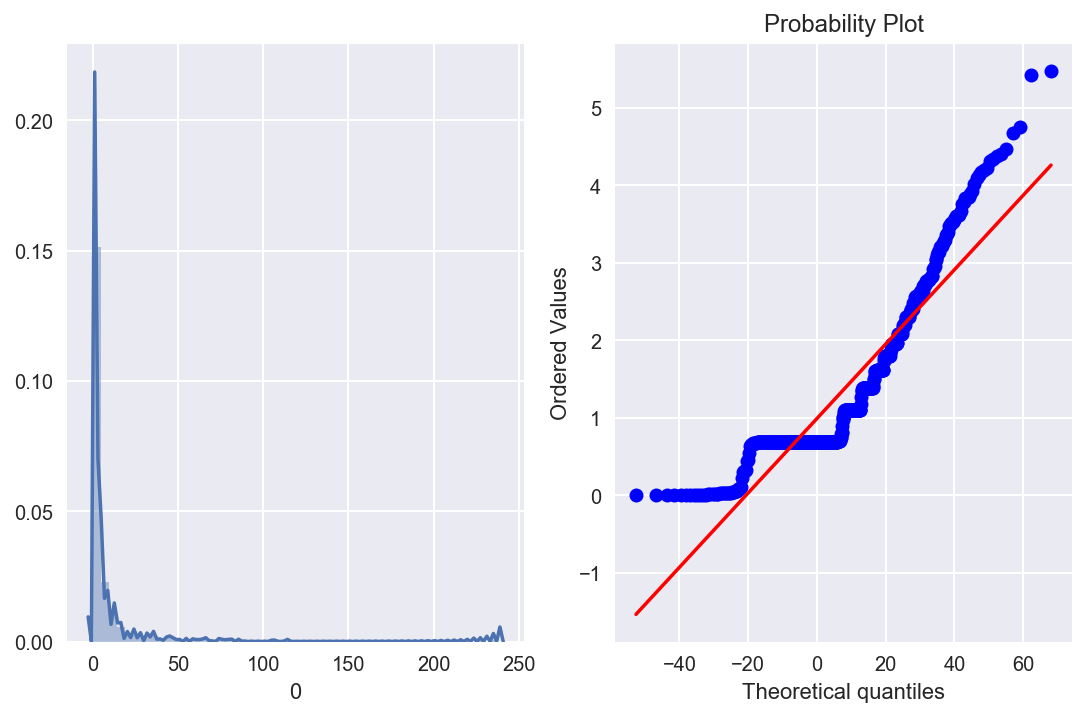

In [6]:
from imp import reload
import probplots
reload(probplots)
from probplots import ProbPlots, plot_dists_pps

tots = cnty_df.values.sum(1)/2  # for double count in aggregation

plot_dists_pps(tots, dist_name='lognorm')

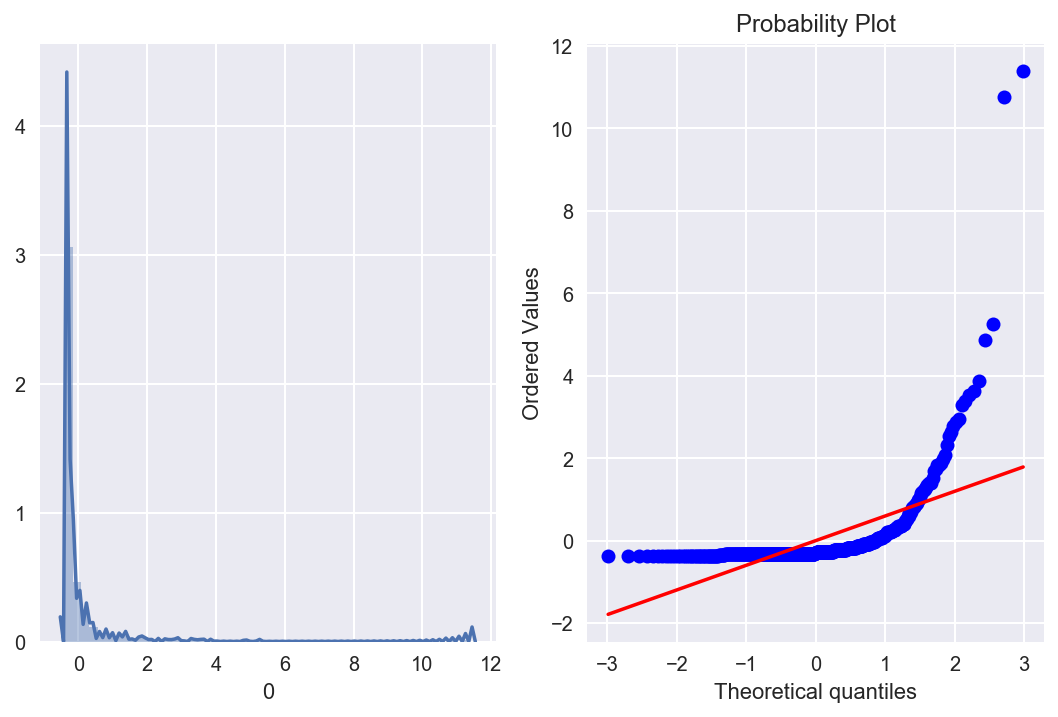

In [7]:
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
tots_scl = scl.fit_transform(tots.reshape(-1, 1))
plot_dists_pps(pd.DataFrame(tots_scl), dist_name='norm')


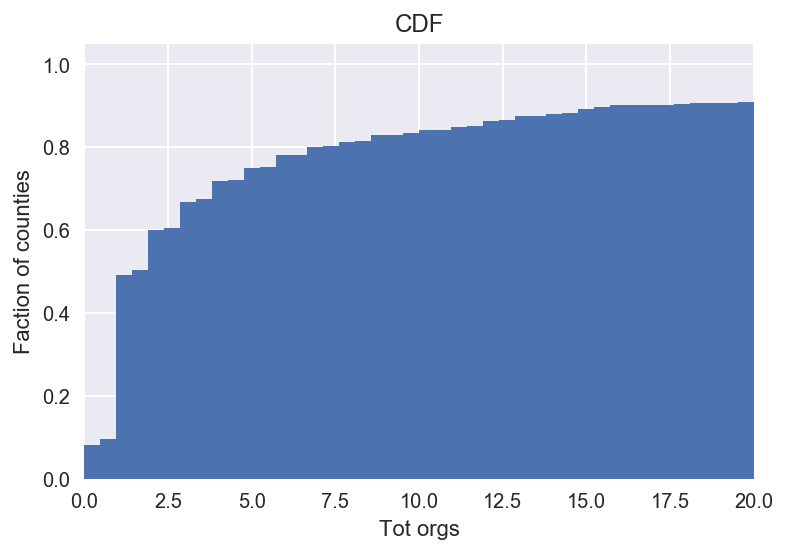

In [8]:

plt.hist(tots, bins=500, cumulative=True, normed=True)
plt.xlabel('Tot orgs')
plt.ylabel('Faction of counties')
plt.title('CDF')
plt.xlim(0, 20)

plt.show()

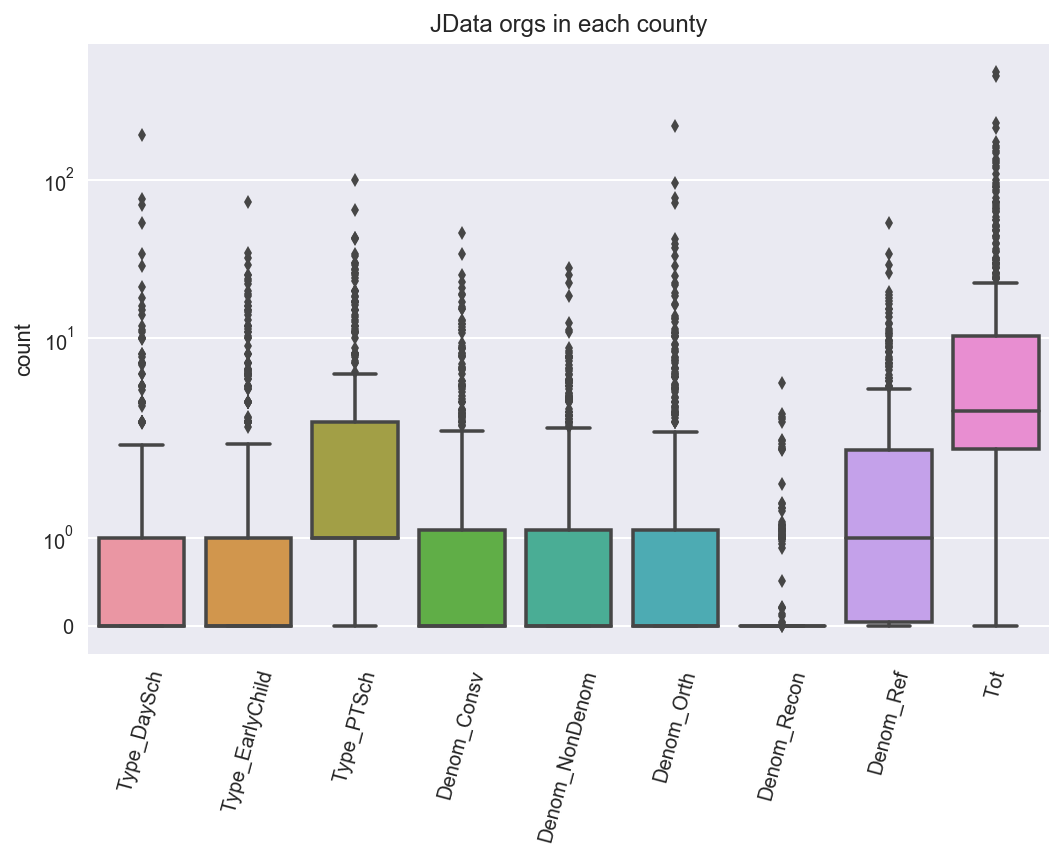

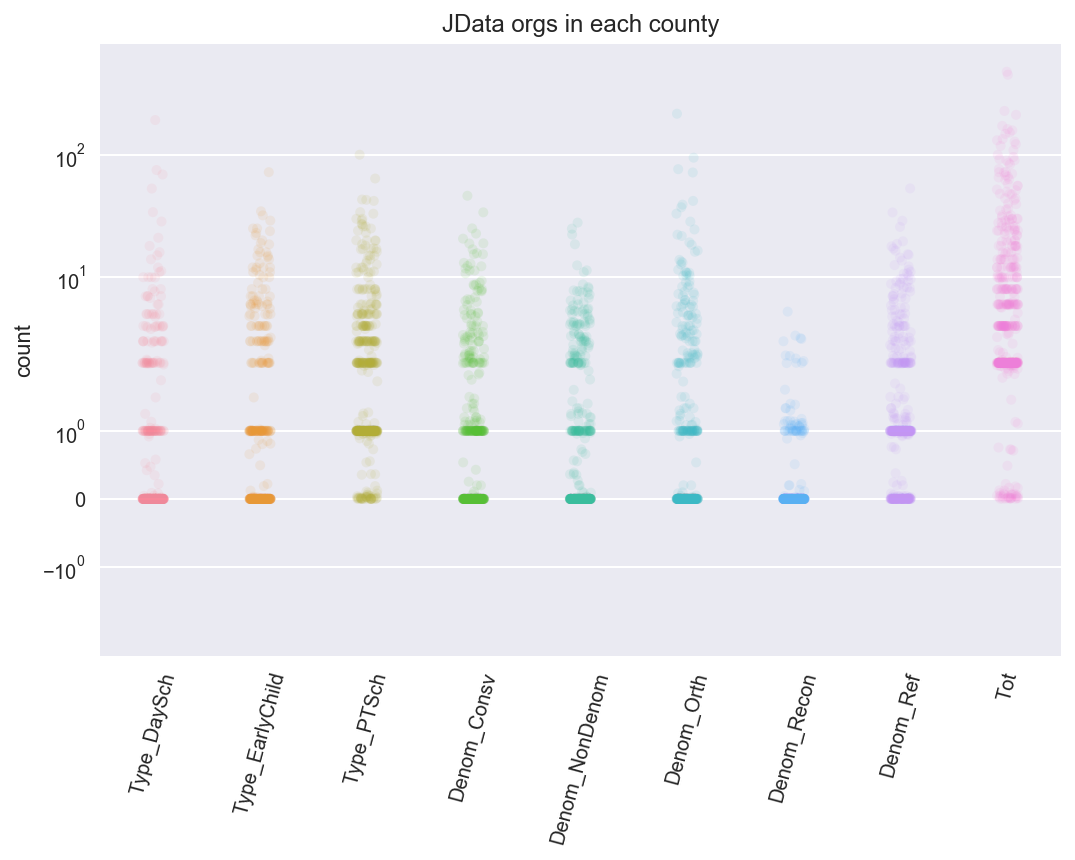

In [9]:
data = pd.melt(
    cnty_df.assign(Tot=cnty_df.sum(1)),
    var_name='type_denom', value_name='count')



# TODO: Use map and facetgrid to overlay

g = sns.factorplot(
    x='type_denom', y='count', data=data, 
    kind='box', size=5, aspect=1.5)

(g.set_xticklabels(rotation=75)
  .set_axis_labels('', 'count')
  .set(yscale='symlog')
  .set(title='JData orgs in each county')
)

g = sns.factorplot(
    x='type_denom', y='count', data=data, 
    kind='strip', size=5, aspect=1.5, jitter=True, alpha=.1)

(g.set_xticklabels(rotation=75)
  .set_axis_labels('', 'count')
  .set(yscale='symlog')
  .set(title='JData orgs in each county')
)
plt.show();

## Preprocessing

### Outlier Detection

In [10]:
def elim_log_tot_outliers(df, out=True):
    """Discard outliers by Tukey of logged total orgs per county."""
    log_sum = np.log(df.sum(1))
    
    is_outlier = is_outlier_val(log_sum)
    df = cnty_df.loc[~is_outlier]
    
    if out:
        print('n outlier: {}'.format(sum(is_outlier)))
        
    return df

def get_log_sum_outliers(df):
    """Returns DataFrame of outlier vals"""
    log_sum = np.log(df.sum(1))
    
    is_outlier = is_outlier_val(log_sum)
    return df.loc[is_outlier]

In [11]:
jdc = JDataCounties(JDATA_FP, ZIPS_TO_FIPS_FP)
cnty_df = jdc.get_county_cnts(exclude=['DayCamp', 'OverCamp'])

cnty_wo_df = cnty_df.copy()
cnty_df = elim_log_tot_outliers(cnty_wo_df)

cnty_type, cnty_denom = cnty_df.iloc[:, :3], cnty_df.iloc[:, 3:]

n outlier: 45


n outlier: 45


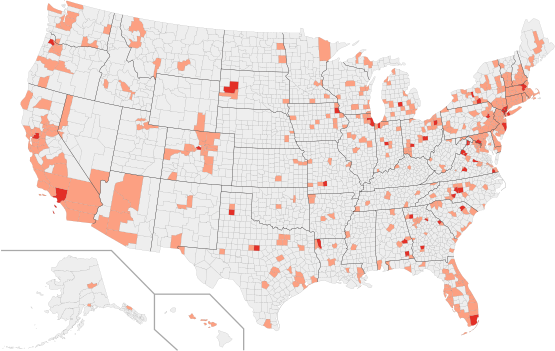

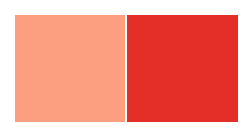

In [12]:
log_sum = np.log(cnty_wo_df.sum(1))
data = is_outlier_val(log_sum)
draw_county_data_svg(data, SVG_FP, colors=2)
print('n outlier: {}'.format(sum(data)))
SVG(SVG_FP)

### Analysis

Ideas:
- Normalize by county totals
    - [StackExchange: Clustering of very skewed, count data: any suggestions to go about (transform etc)?](https://stats.stackexchange.com/questions/173636/clustering-of-very-skewed-count-data-any-suggestions-to-go-about-transform-et)
- Normalize by county populations
- *Ratio across counties*
    - Becausex Facebook targeting will have similar probability of hitting a jewish person

In [33]:
jdc = JDataCounties(JDATA_FP, ZIPS_TO_FIPS_FP)
cnty_df = jdc.get_county_cnts(exclude=['DayCamp', 'OverCamp'])

cnty_type, cnty_denom = cnty_df.iloc[:, :3], cnty_df.iloc[:, 3:]

In [34]:
from sklearn.decomposition import TruncatedSVD, PCA, NMF, FactorAnalysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

class LogScaleByTotal(TransformerMixin):
    """Logs counts normalized by all count total."""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.log(X+1/np.sum(X+1))
    
class LogScaleBySubTotal(TransformerMixin):
    """Logs counts normalized by column total."""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        def f(x): return np.log(x+1/np.sum(x+1))
        return np.apply_along_axis(f, 1, X)
    
class LogStandardScaler(StandardScaler):
    """Standardized logged data."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def fit(self, X, y=None):
        return super().fit(np.log(X+1))
    
    def transform(self, X, y=None):
        return super().transform(np.log(X+1))
    


In [35]:
scaler = LogScaleByTotal()

reducer = PCA()

pipe = Pipeline([
    ('scaler', scaler),
#     ('snd', StandardScaler()),
    ('reducer', reducer)
])
reduced = pipe.fit_transform(cnty_denom)
explained_variance = reducer.explained_variance_ratio_
print(explained_variance)

[ 0.55832377  0.1583229   0.1133224   0.10754212  0.06248881]


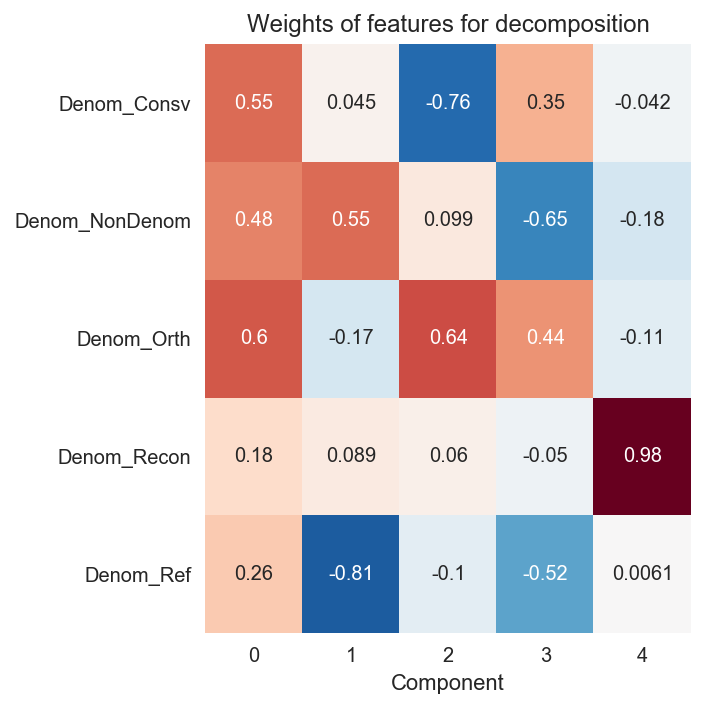

In [36]:
# comps = pd.DataFrame(reducer.components_, columns=data.columns)
plt.figure(figsize=(5, 5))
sns.heatmap(reducer.components_.T, yticklabels=cnty_denom.columns.tolist(),
            cbar=False, annot=True)

plt.title('Weights of features for decomposition')
plt.xlabel('Component')

plt.tight_layout();

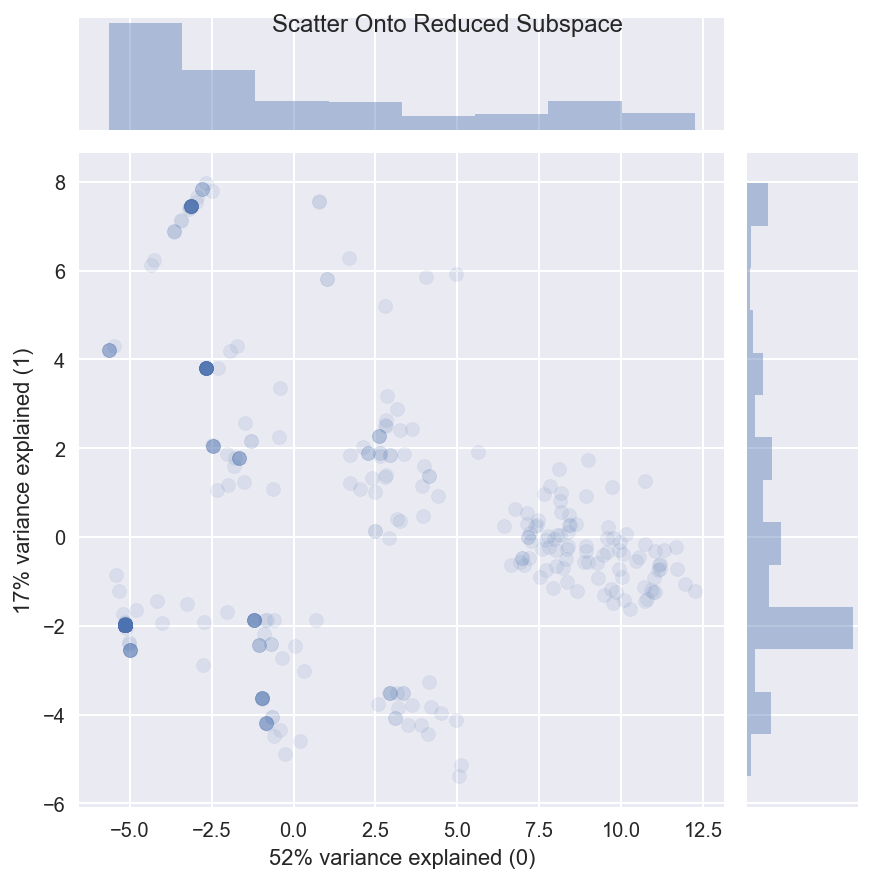

In [24]:
g = sns.jointplot(x=reduced[:, 0], y=reduced[:, 1],
                  alpha=.1, stat_func=None)



comp_0, comp_1, *_ = explained_variance
xlabel = '{:.0%} variance explained (0)'.format(comp_0)
ylabel = '{:.0%} variance explained (1)'.format(comp_1)

g.set_axis_labels(xlabel, ylabel)
g.fig.suptitle('Scatter Onto Reduced Subspace')

plt.show()

In [26]:
def plot_clusters(x, y, data, hue, hue_values=None,
                  rich_legend=True, normalize=True, 
                  alpha=None, **kwargs):
    """Plots scatter with cluster labels as hue.
    
    Sorting testing visually with non-sorted plot
    
    Parameters
    ----------
    x, y, hue : names of variables in ``data``
        Inputs for plotting long-form data. See seaborn dcoumentation examples
        for interpretation.        
    data : DataFrame
        Dataset for plotting. If ``x`` and ``y`` are absent, this is
        interpreted as wide-form. Otherwise it is expected to be long-form. 
    hue_values : list of ints, optional
        Use only these cluster labels for hue, marking the rest as 'x' with
        the exception of outlier label -1 which is kept if present.
    rich_legend : True, bool
        If True, add value count info to clusters in legend, sorted in
        descending order. 
    normalize : True, bool
        If True, normalize value counts in legend.
    alpha : scalar, optional, default: None
        The alpha blending value, between 0 (transparent) and 1 (opaque)
    kwargs : key, value mappings
        Other keyword arguments are passed through to ``plt.scatter`` at draw
        time.
    """
    data = data.copy()
    if hue_values is not None:
        data.loc[:, hue] = data[hue].where(
            lambda x: x.isin(hue_values+[-1]), 'x')
    
    hue_order = None
    if rich_legend:
        cnts = data[hue].value_counts(normalize=normalize)
        new_legend = [(clust, '{:>6} | {:>8.3f}'.format(clust, cnts))
                      for clust, cnts in cnts.iteritems()]
        data = data.replace({hue: dict(new_legend)})
        # Sorting done by value_counts()
        hue_order = list(zip(*new_legend))[1]
    
    # TODO: Prevent alpha from affecting legend.
    return sns.lmplot(x=x, y=y, data=data, hue=hue,
                      fit_reg=False, legend=True,
                      scatter_kws=dict(alpha=alpha),
                      hue_order=hue_order, **kwargs
    )

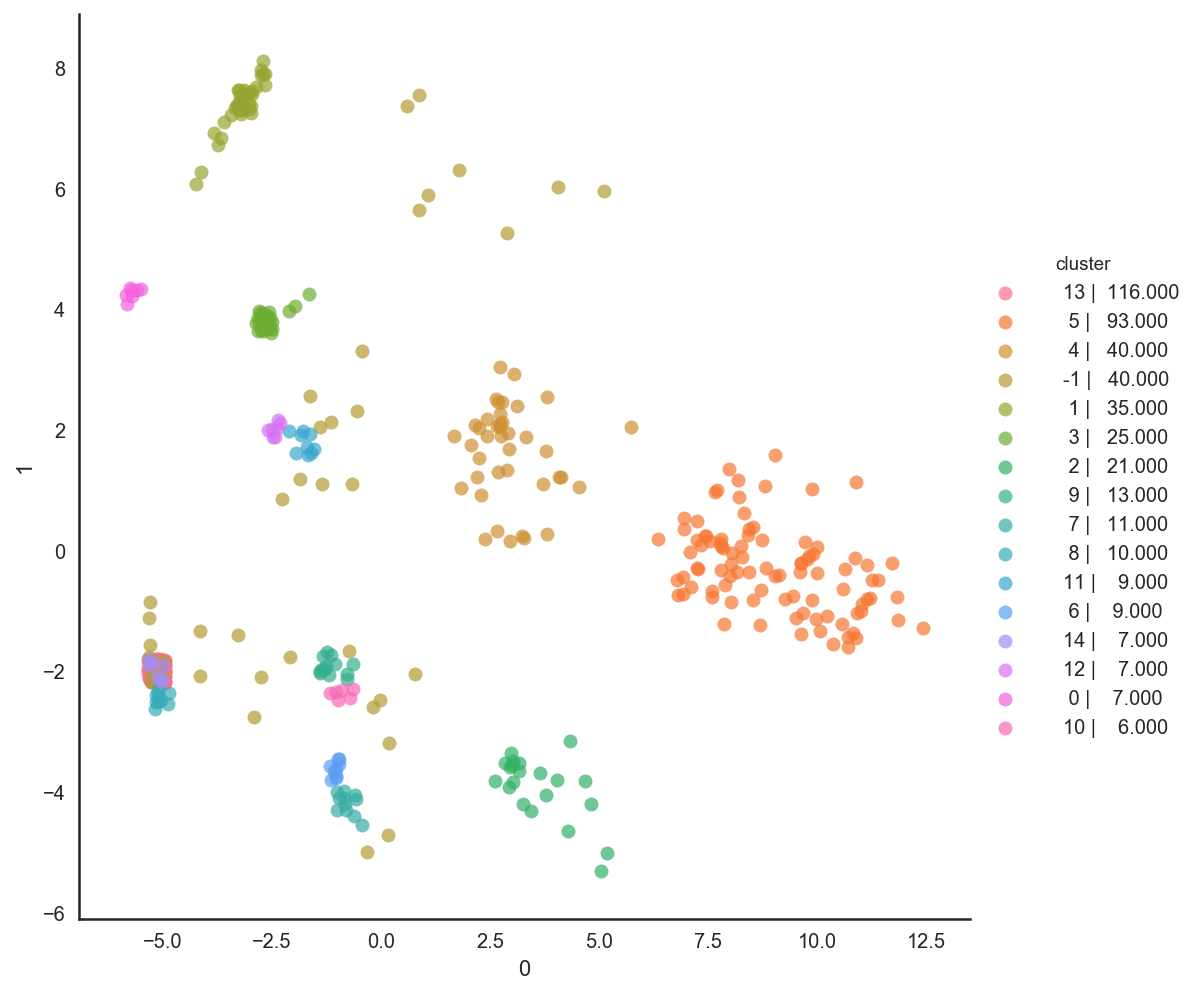

In [30]:
from hdbscan import HDBSCAN

clust_data = reduced[:, :2]
clust = HDBSCAN(min_cluster_size=5, gen_min_span_tree=True).fit(clust_data)
labels = clust.labels_
clust_names = np.unique(labels)

# dense_grp = [7, 8, 9, 10, 11, 12]
# sparse_grp = [0, 1, 2, 3, 4, 5, 6]

# names_used = sorted(dense_grp + sparse_grp)
# names_actual = sorted(clust_names)

# if names_used != names_actual:
#     diff = set(names_used)^set(names_actual)
#     diff.discard(-1)  # don't include -1 in check
#     if diff:
#         warnings.warn('{} missing or not present'.format(set(ls1)^set(ls2)))

hue_values = None
# hue_values = [0, 1, 2, 3, 4, 5, 13]
# hue_values = dense_grp
# hue_values = sparse_grp

data = (pd.DataFrame(clust_data[:, :2])
        .rename(columns=lambda x: str(x))
        .assign(cluster=labels)
)

with sns.axes_style('white'):
    g = plot_clusters(x='0', y='1', data=data, hue='cluster',
                  hue_values=hue_values, rich_legend=True,
                  alpha=.7, size=7, normalize=False,
                  x_jitter=.2, y_jitter=.2
    )
